In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn

import numpy as np
import pandas as pd
from scipy.stats import norm
from urllib.request import urlopen

from torch.distributions.constraints import positive

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.nn import PyroModule

import pyro.poutine as poutine


import os
import sys
parent_dir_abs = os.path.abspath(os.pardir)
sys.path.insert(0, parent_dir_abs) 

from pyro_oed_src import nmc_eig, _safe_mean_terms, mean_field_entropy, _eig_from_ape, posterior_loss
from pyro.contrib.util import lexpand, rexpand

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

import seaborn as sns

import guides
import math

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f'Using device: {device}.')

#set default dtype
torch.set_default_dtype(torch.float64)

Using device: cuda:0.


In [4]:
np_dtype = np.float64
redshifts = np.arange(0, 5, 0.2, dtype=np_dtype)
designs = torch.tensor(redshifts).to(device).unsqueeze(-1)
designs = torch.cat([torch.tensor(redshifts).unsqueeze(-1),
                    torch.tensor(0.698*np.ones(len(redshifts), dtype=np_dtype)).unsqueeze(-1), 
                    torch.tensor(2.330*np.ones(len(redshifts), dtype=np_dtype)).unsqueeze(-1)], axis=-1).to(device)
designs[0:5]

tensor([[0.0000, 0.6980, 2.3300],
        [0.2000, 0.6980, 2.3300],
        [0.4000, 0.6980, 2.3300],
        [0.6000, 0.6980, 2.3300],
        [0.8000, 0.6980, 2.3300]], device='cuda:0')

In [5]:
def model_func(om, z):
    return 29.09/torch.sqrt(om*(1+z)**3+(1-om))

In [6]:
class likelihood_dist(dist.Distribution):
    def __init__(self, om, z, y_1, y_2, sig_0, sig_1, sig_2):
        self.om = om
        self.z = z
        self.y_1 = y_1
        self.y_2 = y_2
        self.sig_0 = sig_0
        self.sig_1 = sig_1
        self.sig_2 = sig_2
        super().__init__()

    def sample(self, sample_shape=torch.Size([])):
        """
        Generate random samples from the distribution.

        Args:
            sample_shape (torch.Size): The shape of the samples to generate.
        Returns:
            torch.Tensor: Random samples from the distribution.
        """
        # sample from a gaussian centered on model prediction with std sigma
        samples = dist.Normal(model_func(self.om, self.z[...,0]), self.sig_0).sample(sample_shape)
        return samples

    def log_prob(self, value):
        """
        Compute the log probability density (log PDF) of the distribution at a given value.

        Args:
            value (torch.Tensor): The value(s) at which to compute the log PDF.
        Returns:
            torch.Tensor: The log PDF of the distribution at the given value(s).
        """
        prob_y_0 = dist.Normal(model_func(self.om, self.z[...,0]), self.sig_0).log_prob(value)
        prob_y_1 = dist.Normal(model_func(self.om, self.z[...,1]), self.sig_1).log_prob(self.y_1)
        prob_y_2 = dist.Normal(model_func(self.om, self.z[...,2]), self.sig_2).log_prob(self.y_2)
        log_prob = prob_y_0+prob_y_1+prob_y_2
        return log_prob

In [7]:
om_prior = torch.tensor(0.31, device=device) # Gaussian prior mean
sigma_prior = torch.tensor(0.02, device=device) # Gaussian prior std
sig_0 = torch.tensor(0.2, device=device) # Gaussian likelihood std
y_1 = torch.tensor(19.770, device=device) # LRG measurements mean
sig_1 = torch.tensor(0.47, device=device) # LRG measurements std
y_2 = torch.tensor(8.99, device=device) # Lyman-alpha measurements mean
sig_2 = torch.tensor(0.19, device=device) # Lyman-alpha measurements std

def model(z):
    with pyro.plate_stack("plate", z.shape[:-1]):
        om = pyro.sample("om", dist.Normal(om_prior,sigma_prior)) # shape: [n,num_designs,1]
        likelihood = likelihood_dist(om, z, y_1, y_2, sig_0, sig_1, sig_2)
        return pyro.sample("y", likelihood)


cosmo_posterior(
  (nn): dense_nn(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): Sigmoid()
      (6): Linear(in_features=32, out_features=2, bias=True)
    )
  )
)


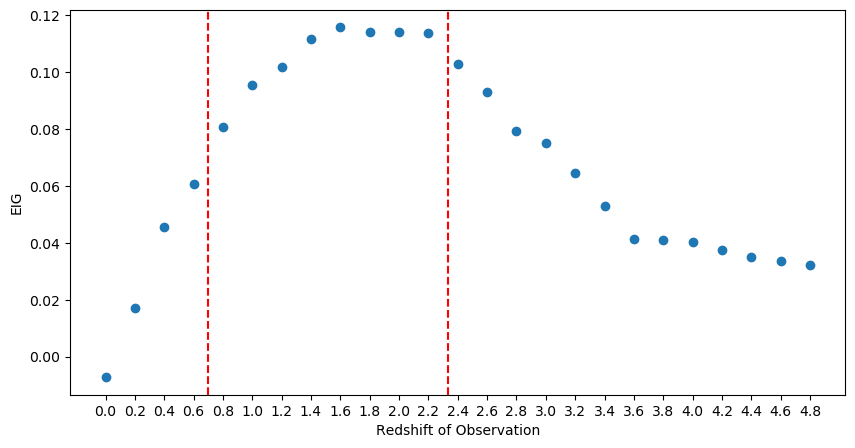

In [8]:
pyro.clear_param_store()
pyro.set_rng_seed(0)
observation_labels = ["y"]
target_labels = ["om"]
N = 200
training_steps = 5000
return_history = True

lr = 5e-4
optim = pyro.optim.Adam({"lr": lr})

input_features = 4
output_features = 2

lay_1 = 16
lay_2 = 32
lay_3 = 32
guide = guides.cosmo_posterior(input_features, lay_1, lay_2, lay_3, output_features, device, amor_design=True, batch_norm=False)
print(guide)

params = None
history = []
for step in range(training_steps):
    if params is not None:
        pyro.infer.util.zero_grads(params)
    with poutine.trace(param_only=True) as param_capture:
        agg_loss, loss = posterior_loss(design=designs,
                                        model=model,
                                        guide=guide,
                                        num_particles=N,
                                        observation_labels=observation_labels,
                                        target_labels=target_labels)
    params = set(
        site["value"].unconstrained() for site in param_capture.trace.nodes.values())
    if torch.isnan(agg_loss):
        raise ArithmeticError("Encountered NaN loss in opt_eig_ape_loss")
    agg_loss.backward(retain_graph=True)
    if return_history:
        history.append(loss)
    optim(params)
    try:
        optim.step()
    except AttributeError:
        pass

    history.append(loss)

stacked_history = torch.stack(history)
history_array = stacked_history.cpu().detach().numpy()

eigs = []
for i in range(len(designs)):
    _, ape = posterior_loss(designs[i].unsqueeze(-2), model, guide, 100000, observation_labels, target_labels)
    eigs.append(_eig_from_ape(model, designs[i].unsqueeze(-2), target_labels, ape, True, {}).item())
eigs = np.array(eigs)

plt.figure(figsize=(10,5))
plt.plot(redshifts, eigs, 'o')
# plot vertical line of the previous measurements
plt.axvline(x=0.698, color='r', linestyle='--')
plt.axvline(x=2.330, color='r', linestyle='--')
plt.xticks(np.round(redshifts, 2))
plt.xlabel("Redshift of Observation")
plt.ylabel("EIG")
plt.show()